In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [12]:

def display_images(images, titles, figsize=(15, 5)):
    """
    Helper function to display multiple images side by side
    """
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]
    
    for img, title, ax in zip(images, titles, axes):
        if len(img.shape) == 2:  # Grayscale image
            ax.imshow(img, cmap='gray')
        else:  # Color image
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [13]:
# Load the grayscale image
image_path = './Images/sudoku_full.jpg'  # Replace with your image path
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Binary Thresholding (Manual Implementation)
def binary_threshold(image, threshold):
    result = np.zeros_like(image)
    result[image > threshold] = 255
    return result

# Adaptive Thresholding (Mean of Neighborhood)
def adaptive_threshold(image, block_size, C):
    padded_image = np.pad(image, block_size // 2, mode='constant', constant_values=0)
    result = np.zeros_like(image)
     # Get flattened indices for a single loop
    rows, cols = image.shape
    total_pixels = rows * cols

    for idx in range(total_pixels):
        # Convert flat index to 2D indices
        i, j = divmod(idx, cols)

        # Extract local region
        local_region = padded_image[i:i + block_size, j:j + block_size]
        
        # Compute local mean
        local_mean = np.mean(local_region)
        
        # Apply thresholding
        result[i, j] = 255 if image[i, j] > (local_mean - C) else 0
    return result

# Otsu's Thresholding (Manual Implementation)
def otsu_threshold(image):
    hist, bins = np.histogram(image.ravel(), 256, [0, 256])
    total_pixels = image.size
    current_max, threshold = 0, 0
    sum_total, sum_foreground = np.dot(hist, np.arange(256)), 0
    weight_background, weight_foreground = 0, 0
    
    for i in range(256):
        weight_background += hist[i]
        if weight_background == 0:
            continue
        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break
        
        sum_foreground += i * hist[i]
        mean_background = sum_foreground / weight_background
        mean_foreground = (sum_total - sum_foreground) / weight_foreground
        
        # Calculate Between-Class Variance
        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        
        # Find maximum variance
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = i
    
    # Apply the found threshold
    return binary_threshold(image, threshold)


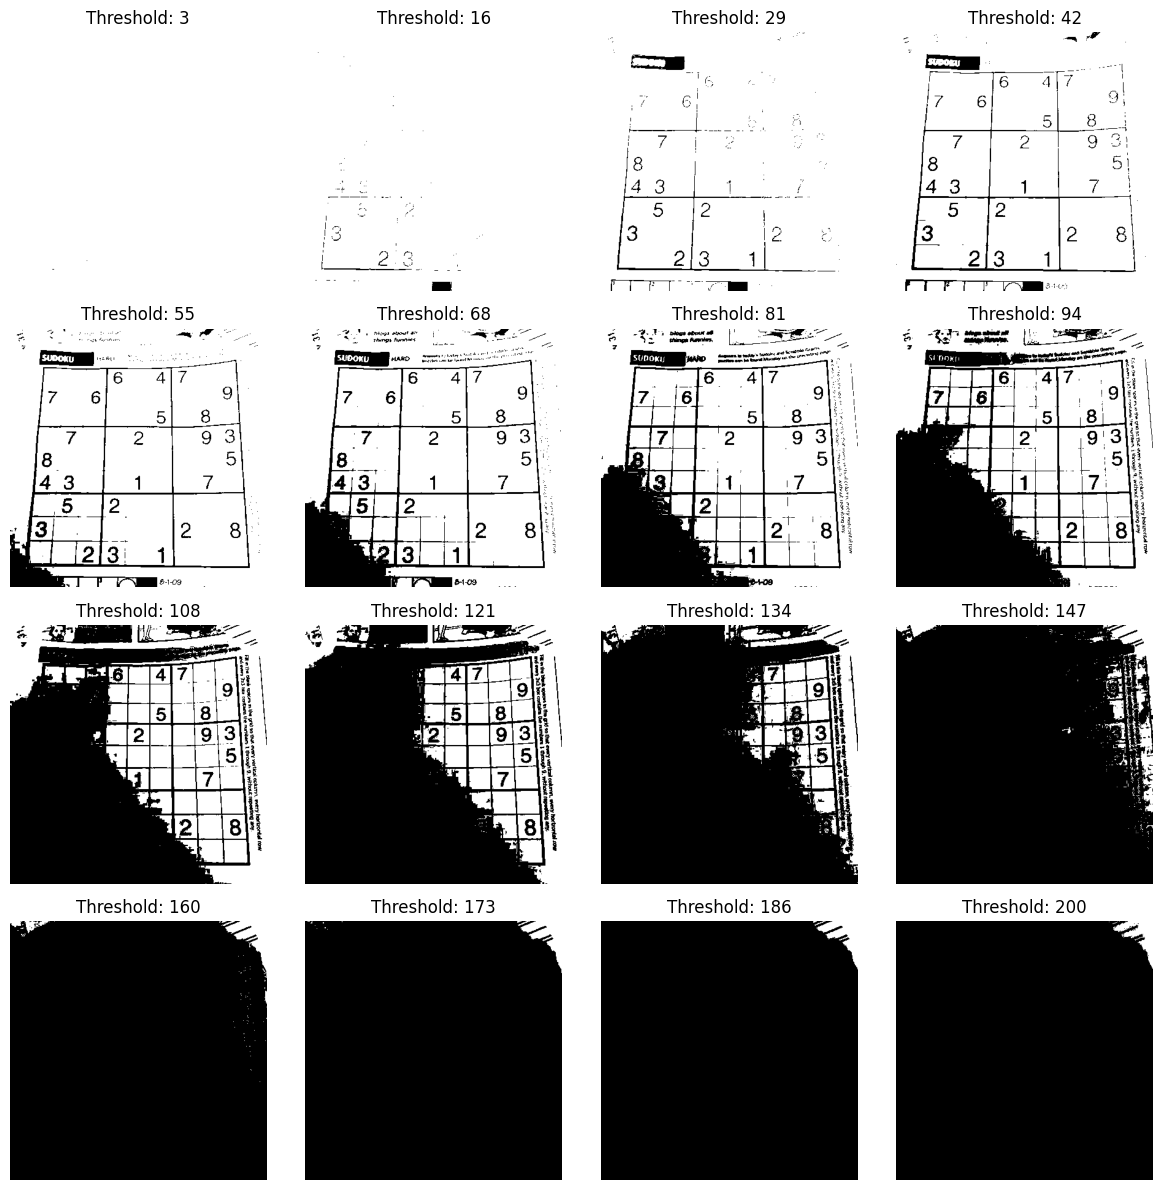

In [14]:
# Define thresholds
thresholds = np.linspace(3, 200, 16, dtype=int)
# Create a figure
plt.figure(figsize=(12, 12))

# Plot original image
plt.subplot(4, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Apply different thresholds and plot
for i, thresh in enumerate(thresholds, start=1):
    binary_image = binary_threshold(gray_image, thresh)
    plt.subplot(4, 4, i)
    plt.imshow(binary_image, cmap='gray')
    plt.title(f'Threshold: {thresh}')
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

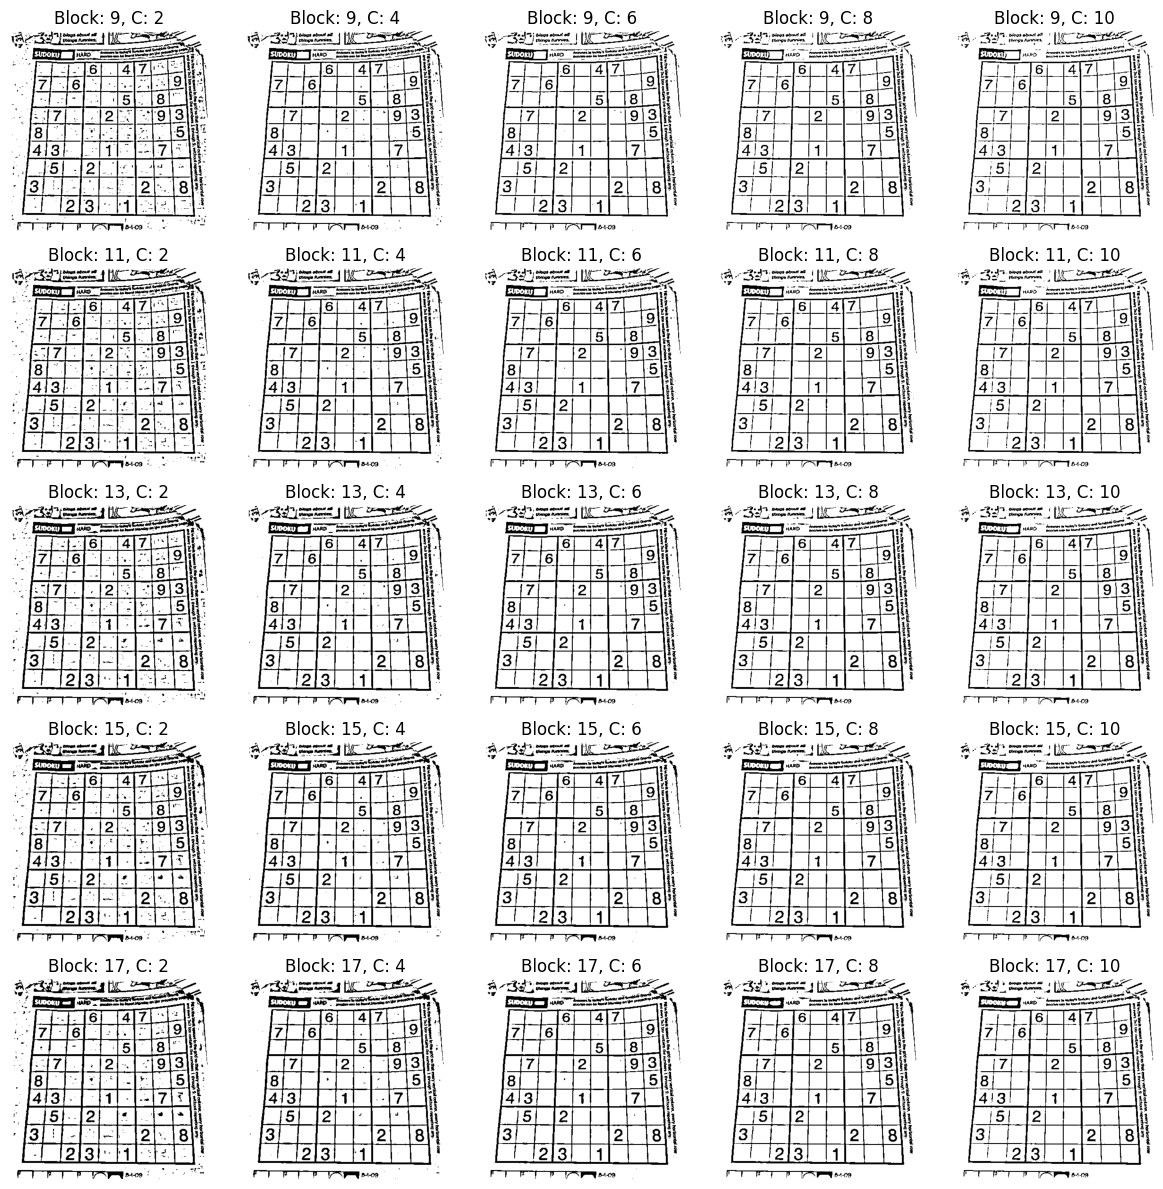

In [15]:
# Define block sizes and C values
block_sizes = [9, 11, 13, 15, 17]
C_values = [2, 4, 6, 8, 10]

# Create a figure
plt.figure(figsize=(12, 12))

# Plot original image
plt.subplot(5, 5, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original')
plt.axis('off')

# Apply different adaptive thresholds and plot
index = 1
for block_size in block_sizes:
    for C in C_values:
        adaptive_thresh = adaptive_threshold(gray_image, block_size, C)
        plt.subplot(5, 5, index)
        plt.imshow(adaptive_thresh, cmap='gray')
        plt.title(f'Block: {block_size}, C: {C}')
        plt.axis('off')
        index += 1

# Show the plot
plt.tight_layout()
plt.show()

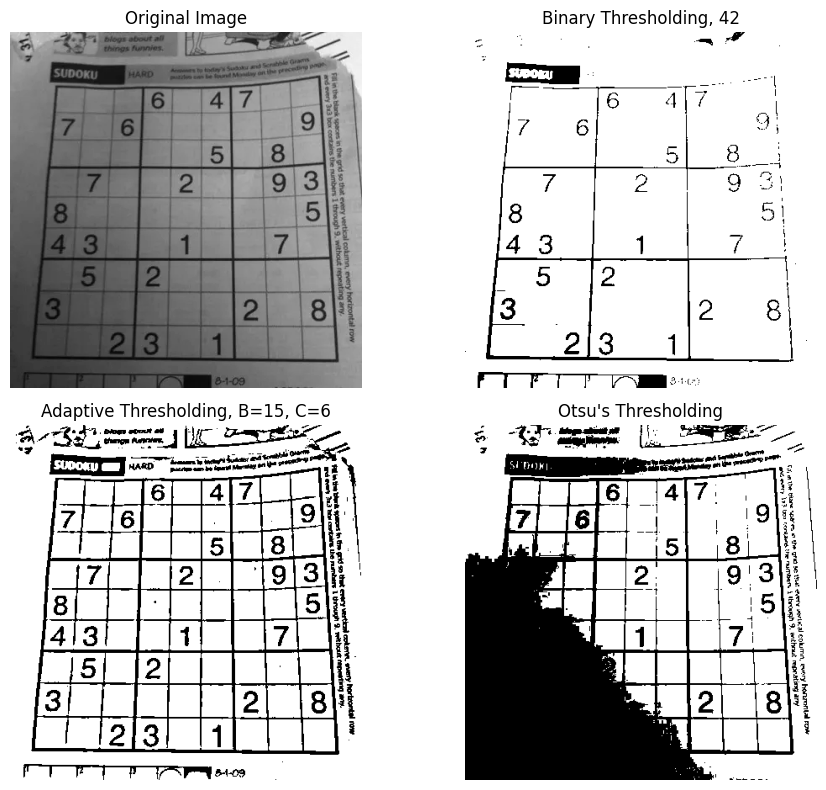

In [16]:
''' Best bianry thresholding is 42 '''
''' Best adaptive thresholding is block_size=15, C=6 '''

binary_thresh = binary_threshold(gray_image, 42)
adaptive_thresh = adaptive_threshold(gray_image, block_size=15, C=6)
otsu_thresh = otsu_threshold(gray_image)

# Display Results
titles = ['Original Image', 'Binary Thresholding, 42', 'Adaptive Thresholding, B=15, C=6', "Otsu's Thresholding"]
images = [gray_image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


### Binary Thresholding  
Binary Thresholding is simple and effective for images with high contrast between objects and the background. However, it struggles with uneven lighting, resulting in unclear boundaries and loss of detail in shaded or overexposed regions.

### Adaptive Thresholding  
Adaptive Thresholding performs well in images with non-uniform illumination, preserving object boundaries even in varying lighting conditions. However, it may introduce noise or over-segmentation in areas with subtle intensity variations.

### Otsu’s Thresholding  
Otsu’s Thresholding automatically finds the optimal threshold and is particularly effective for images with bimodal histograms. It produces clear object boundaries and reduces noise, though it may fail in images with complex lighting or intensity distributions.

In [17]:
def detect_lines(image, canny_threshold1, canny_threshold2, hough_threshold, min_line_length, max_line_gap):
    # Step 1: Apply Canny Edge Detection
    edges = cv2.Canny(image, canny_threshold1, canny_threshold2)

    # Step 2: Apply Hough Line Transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=hough_threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Step 3: Draw Detected Lines on a Copy of the Original Image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for colored lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines with thickness 2

    return output_image, edges

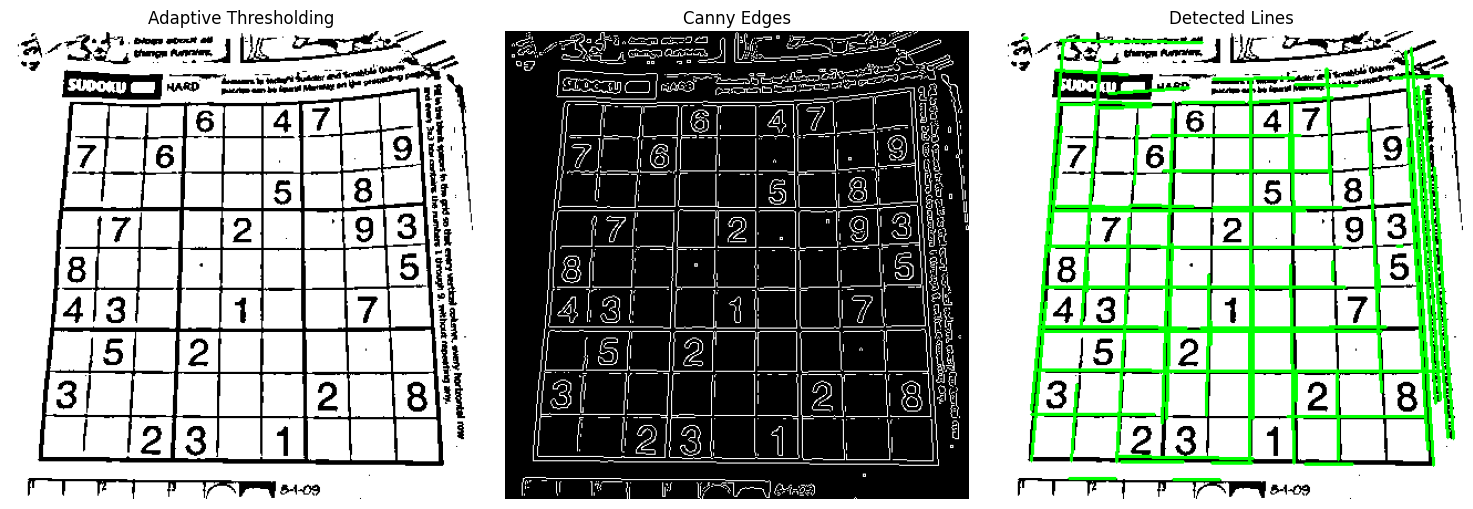

In [18]:
# Task 2
img_path = './Images/sudoku_full.jpg'  # Replace with your image path
line_result, edges = detect_lines(adaptive_thresh, 50, 150, 100, 0, 10)

# Display Results
display_images([adaptive_thresh, edges, line_result], ['Adaptive Thresholding', 'Canny Edges', 'Detected Lines'])

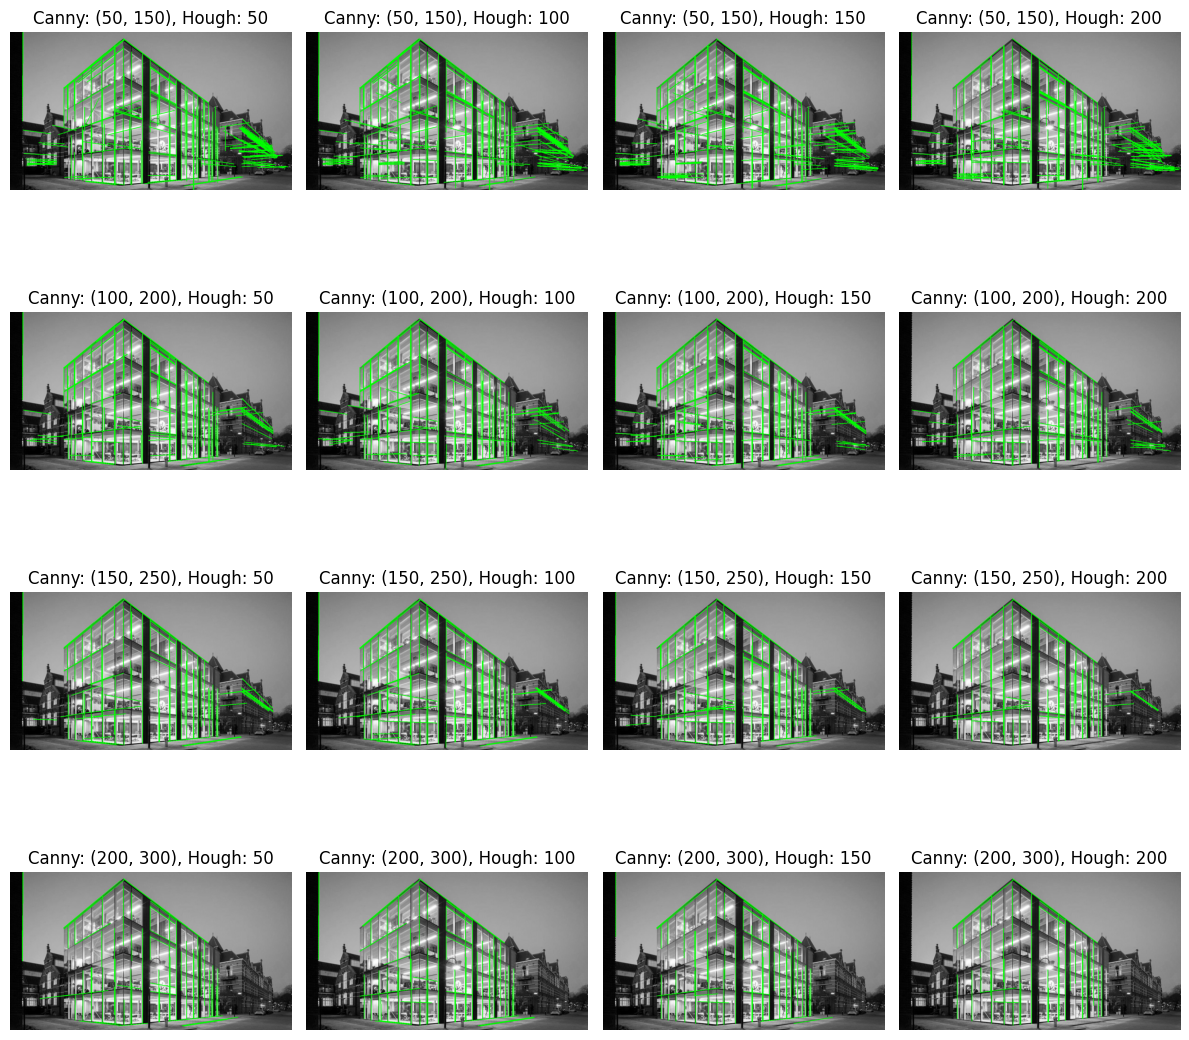

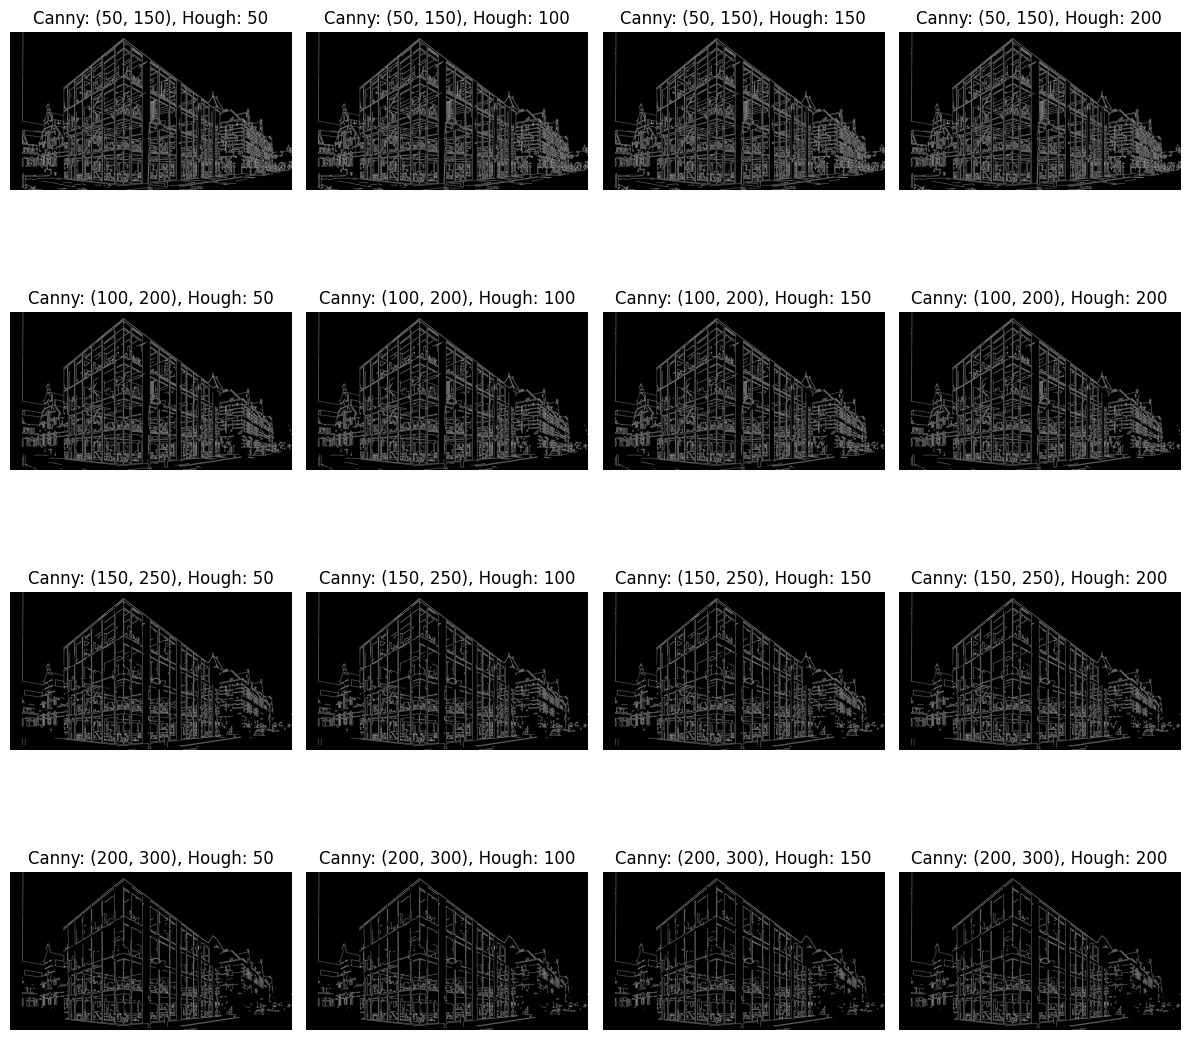

In [19]:
# Load the image
img_path = './Images/building.png'  # Replace with your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Define different values for Hough Transform parameters
canny_thresholds = [(50, 150), (100, 200), (150, 250), (200, 300)]
hough_thresholds = [50, 100, 150, 200]

# Prepare images for display
images = []
titles = []
edges_list = []

for canny_threshold1, canny_threshold2 in canny_thresholds:
    for hough_threshold in hough_thresholds:
        line_result, edges = detect_lines(img, canny_threshold1, canny_threshold2, hough_threshold, 100, 10)
        images.append(line_result)
        edges_list.append(edges)
        titles.append(f'Canny: ({canny_threshold1}, {canny_threshold2}), Hough: {hough_threshold}')

def display_images(images, titles):
    plt.figure(figsize=(12, 12))
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(4, 4, i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if len(image.shape) == 3 else image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(images, titles)
display_images(edges_list, titles)

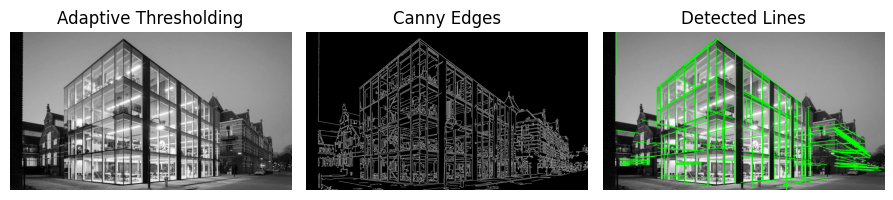

In [20]:
# Task 2
img_path = './Images/building.png'  # Replace with your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
line_result, edges = detect_lines(img, 50, 150, 100, 100, 10)

# Display Results
display_images([img, edges, line_result], ['Adaptive Thresholding', 'Canny Edges', 'Detected Lines'])

Increasing the threshold parameter in the Hough Line Transform reduces the number of detected lines. This is because only lines that accumulate a higher number of votes (i.e., points along the line) are considered valid. As a result, shorter or less prominent lines may be missed. Conversely, decreasing the threshold allows for more lines to be detected, including those that are shorter or less distinct. However, this can also introduce more noise and false positives, as more line candidates are accepted.

This effect is clearly visible in the images above: as the threshold increases, the number of detected lines decreases, and only the most prominent lines are shown.

# Task 3

In [61]:
def detect_circles(image, dp, min_dist, param1, param2, min_radius, max_radius):
    # apply edge detection
    # edges = cv2.Canny(image, 100, 200)

    # thresholding otsu
    edges = otsu_threshold(image)

    # Step 1: Preprocess the Image (Smoothing)
    blurred_image = cv2.GaussianBlur(image, (9, 9), 3)
    
    # Step 2: Apply Hough Circle Transform
    circles = cv2.HoughCircles(blurred_image, cv2.HOUGH_GRADIENT, dp=dp, minDist=min_dist,
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
    
    # print(circles)
    
    # Step 3: Draw Detected Circles
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for colored circles
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round and convert to integers
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # Circle center
            radius = circle[2]  # Circle radius
            cv2.circle(output_image, center, radius, (0, 255, 0), 2)  # Draw circle perimeter
            cv2.circle(output_image, center, 2, (0, 0, 255), 3)  # Draw circle center

    return output_image, edges


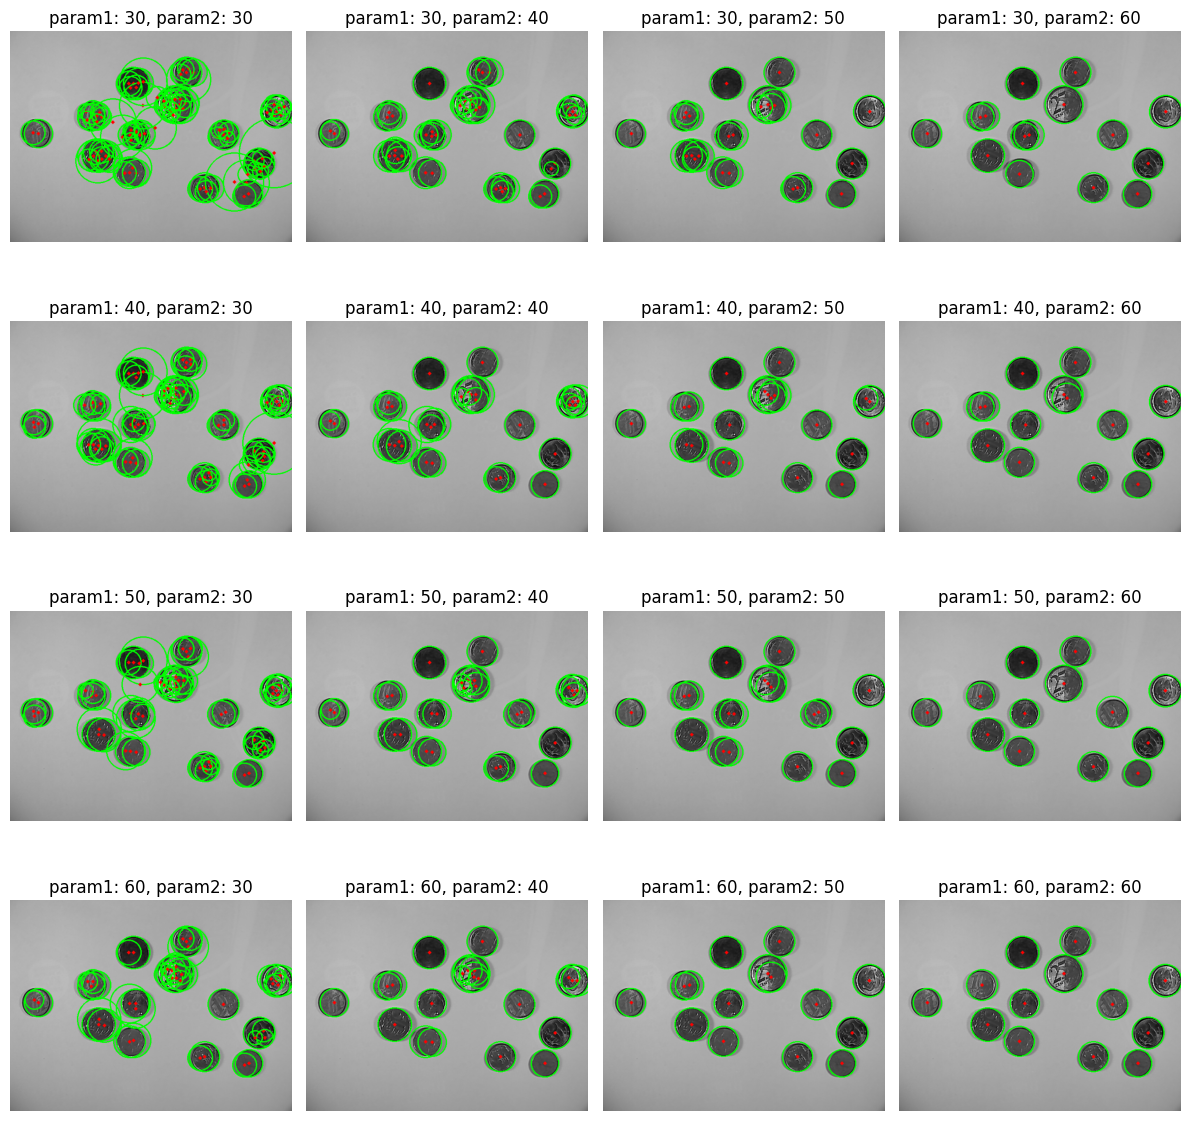

In [63]:
# Load an image with circles
image_path = './Images/coin-detection.jpg'  # Replace with an appropriate image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define different values for Hough Circle Transform parameters
param1_values = [30, 40, 50, 60]
param2_values = [30, 40, 50, 60]

# Prepare images for display
images = []
titles = []
edges_list = []

for param1 in param1_values:
    for param2 in param2_values:
        circle_result, edges = detect_circles(img, dp=1.2, min_dist=10, param1=param1, param2=param2, 
                                 min_radius=10, max_radius=80)
        images.append(circle_result)
        titles.append(f'param1: {param1}, param2: {param2}')
        edges_list.append(edges)

# Display Results
display_images(images, titles)
# display_images(edges_list, titles)

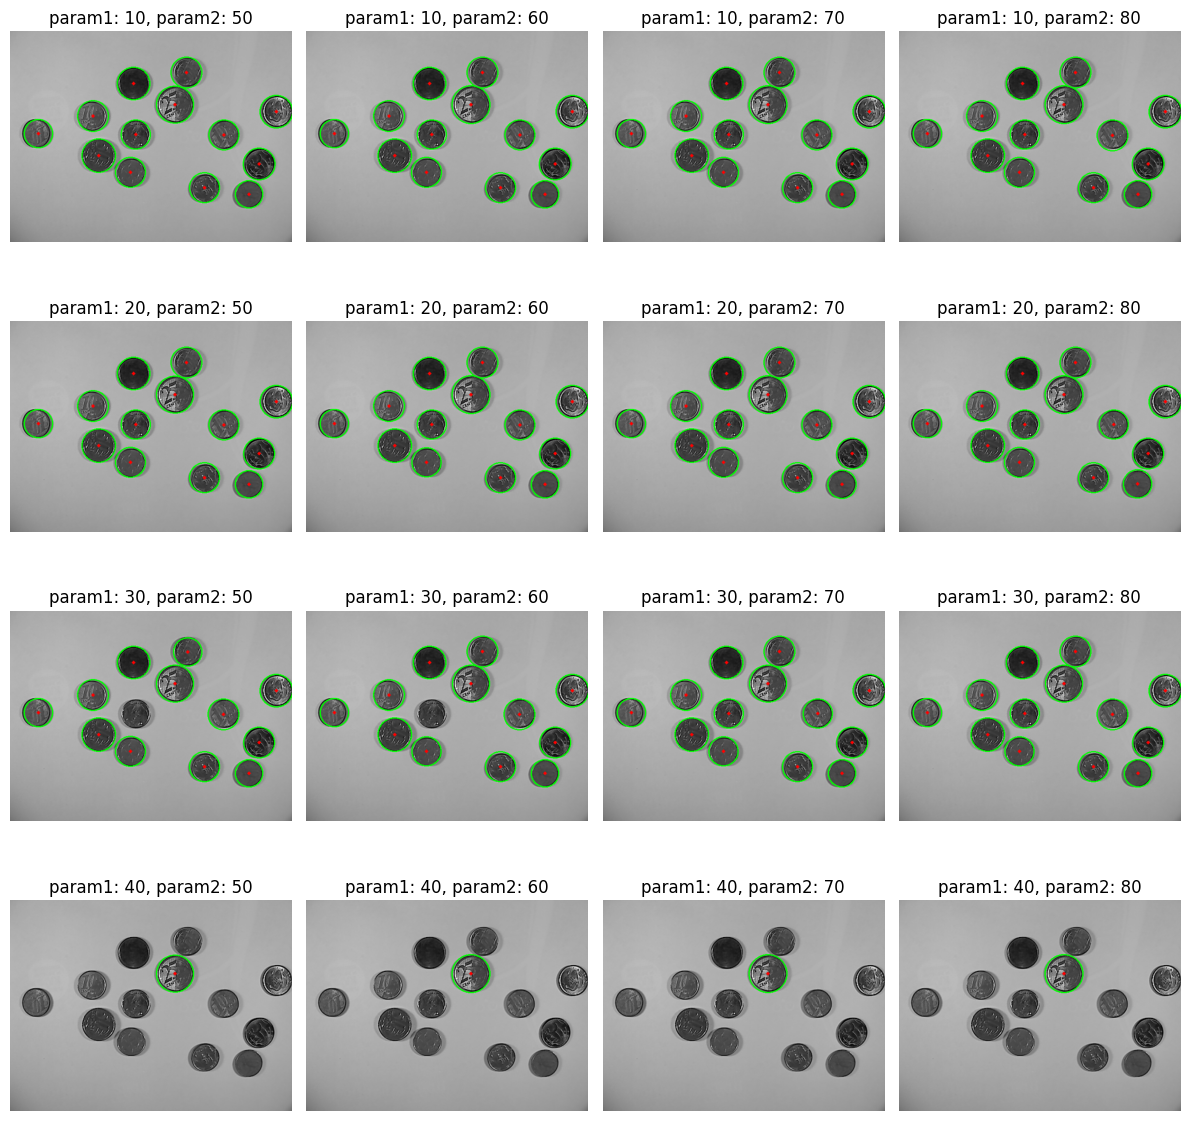

In [66]:
# Load an image with circles
image_path = './Images/coin-detection.jpg'  # Replace with an appropriate image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define different values for Hough Circle Transform parameters
min_radius = [10, 20, 30, 40]
max_radius = [50, 60, 70, 80]

# Prepare images for display
images = []
titles = []
edges_list = []

for param1 in min_radius:
    for param2 in max_radius:
        circle_result, edges = detect_circles(img, dp=1.2, min_dist=10, param1=60, param2=60, 
                                 min_radius=param1, max_radius=param2)
        images.append(circle_result)
        titles.append(f'param1: {param1}, param2: {param2}')
        edges_list.append(edges)

# Display Results
display_images(images, titles)
# display_images(edges_list, titles)

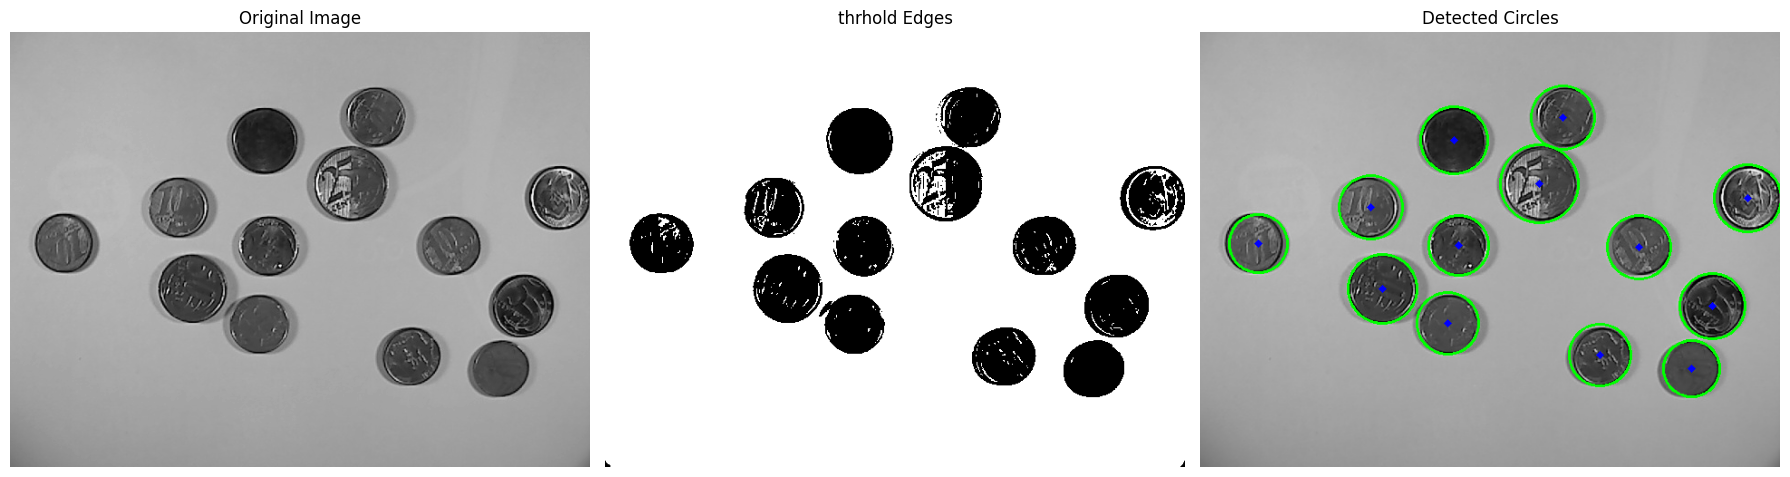

In [46]:
# Load an image with circles
image_path = './Images/coin-detection.jpg'  # Replace with an appropriate image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Detect circles
processed_image, edges = detect_circles(image, dp=1.2, min_dist=30, param1=60, param2=60, 
                                 min_radius=10, max_radius=80)

# Display the original and processed images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('thrhold Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed_image, cmap='gray')
plt.title('Detected Circles')
plt.axis('off')

plt.tight_layout()
plt.show()


In [171]:
def harris_corner_detection_old(image, block_size, ksize, k, threshold):
    # Convert image to float32
    gray = np.float32(image)
    
    # Apply Harris corner detection
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    
    # Result is dilated for marking the corners, not important
    dst = cv2.dilate(dst, None)
    
    # Threshold for an optimal value, it may vary depending on the image
    image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image_with_corners[dst > threshold * dst.max()] = [0, 0, 255]
    
    return image_with_corners

def harris_corner_detection(image, block_size, ksize, k, threshold, d=9, sigma_color=75, sigma_space=75, equalize_hist=False):
    """
    Detects and marks corners in an image using the Harris Corner Detection method with preprocessing.

    Parameters:
        image (np.ndarray): Input grayscale image.
        block_size (int): Neighborhood size for corner detection.
        ksize (int): Aperture size for the Sobel operator.
        k (float): Harris detector free parameter, typically in the range [0.04, 0.06].
        threshold (float): Threshold for detecting strong corners (relative to max response).
        d (int): Diameter of the bilateral filter pixel neighborhood.
        sigma_color (float): Filter sigma in the color space for the bilateral filter.
        sigma_space (float): Filter sigma in the coordinate space for the bilateral filter.
        equalize_hist (bool): Whether to apply histogram equalization.

    Returns:
        np.ndarray: Image with detected corners marked.
    """
    # sharpen the image

    # Step 1: Apply bilateral filter to reduce noise while preserving edges
    img_filtered = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    edges = cv2.Canny(img_filtered, 50, 150)

    # Step 2: Optionally apply histogram equalization to enhance contrast
    if equalize_hist:
        img_filtered = cv2.equalizeHist(img_filtered)

    # Step 3: Convert img_filtered to float32 (required for Harris Corner Detection)
    gray_float = np.float32(img_filtered)
    
    # Step 4: Apply Harris Corner Detection
    corner_response = cv2.cornerHarris(gray_float, block_size, ksize, k)
    
    # Step 5: Dilate corner response for better visualization
    dilated_response = cv2.dilate(corner_response, None)
    
    # Step 6: Threshold for detecting strong corners
    corners = dilated_response > threshold * dilated_response.max()
    
    # Step 7: Mark the detected corners on the original image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    output_image[corners] = [0, 0, 255]  # Mark corners in red

    return output_image

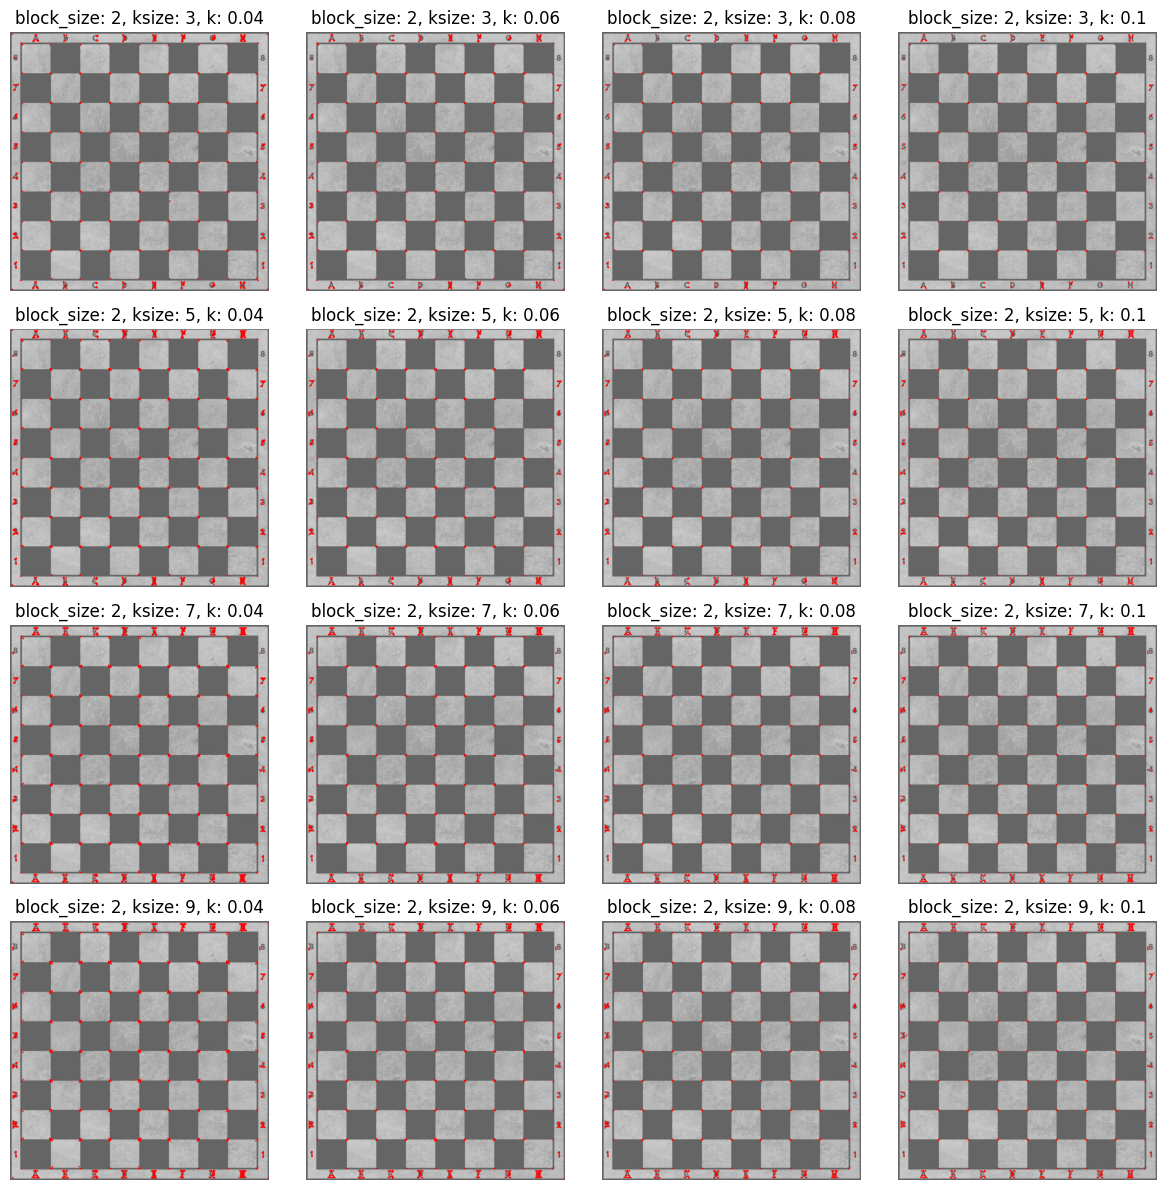

In [172]:
# Define different values for Harris Corner Detection parameters
block_sizes = [2, 3, 4, 5]
ksizes = [3, 5, 7, 9]
k_values = [0.04, 0.06, 0.08, 0.1]

# Prepare images for display
images = []
titles = []
# edges_list = []

for block_size in block_sizes:
    for ksize in ksizes:
        for k in k_values:
            processed_image = harris_corner_detection(image, block_size, ksize, k, 0.01, d=9, sigma_color=75, sigma_space=150, equalize_hist=False)
            # edges_list.append(edges)
            images.append(processed_image)
            titles.append(f'block_size: {block_size}, ksize: {ksize}, k: {k}')

# Display Results
display_images(images[:16], titles[:16])  # Display only the first 16 combinations
# display_images(edges_list[:16], titles[:16])  # Display only the first 16 combinations

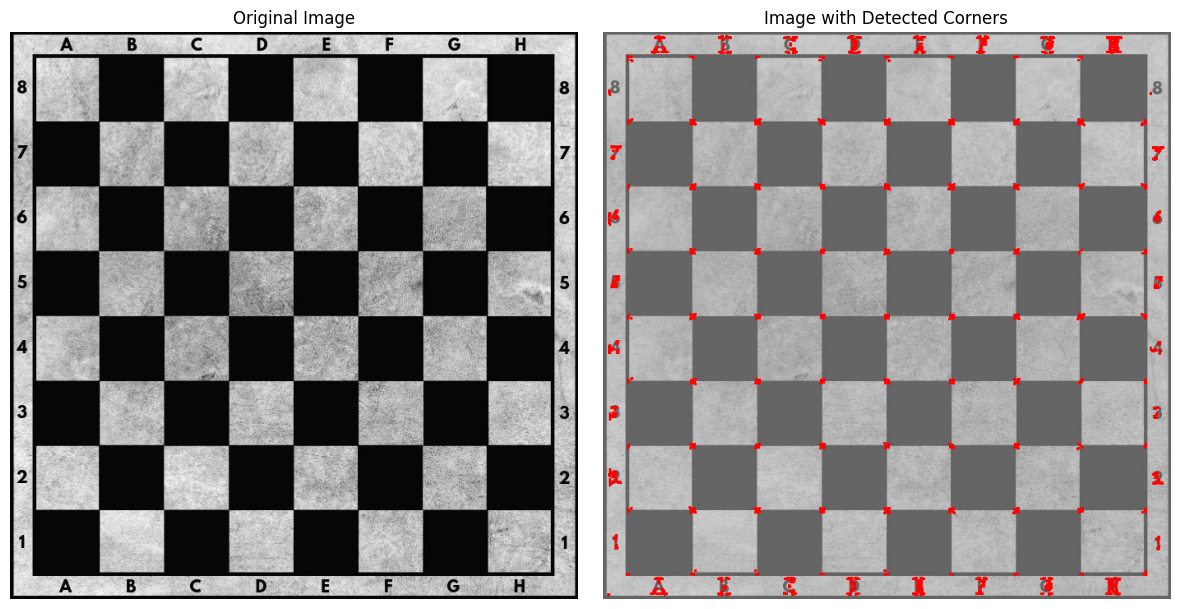

In [173]:
# Load an example grayscale image
image_path = './Images/image_copy_2.png'  # Replace with an appropriate image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Detect and mark corners
processed_image = harris_corner_detection(image, block_size=2, ksize=7, k=0.04, threshold=0.01, d=9, sigma_color=75, sigma_space=150, equalize_hist=False)

# Display the original and processed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with Detected Corners')
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


It is a constant used in the calculation of the corner response function, influencing how much emphasis is placed on corner-like regions versus edge-like or flat regions. Typically, k is a value between 0.04 and 0.06. A lower k leads to more corners being detected, including noise, while a higher k makes the detector more selective, detecting only the most prominent corners and ignoring weak ones

Higher k => higher sensitivity => only prominent conners detected


k=0.8 works the best

# Task 5

The Hough Transform detects **lines** by mapping points in the image to curves in a 2D parameter space (ρ, θ), where ρ represents the perpendicular distance from the origin, and θ is the angle of the normal. For **circles**, the parameter space increases to three dimensions (a, b, r), where (a, b) are the circle’s center coordinates and r is its radius. This increase arises because a circle requires three parameters to define, unlike a line which only needs two.

Detecting circles is computationally more complex due to the higher dimensional parameter space, requiring more memory and processing time. In practice, to reduce complexity, the radius (r) is often fixed or constrained. For lines, accumulation in a 2D space is faster and simpler, while circles demand more iterations and votes in a 3D space, making detection slower and resource-intensive.
